In [33]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer, MinimumEigenOptimizationResult
from qiskit_algorithms.utils import algorithm_globals

In [ ]:
def get_portfolio_data(tickers, start_date, end_date):
    """
    Fetches historical data and calculates expected return (mu) and covariance (sigma).
    """
    #Fetch raw data from Yahoo Finance

    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    
    #Calculate daily returns (percentage change)
    daily_returns = data.pct_change().dropna()
    
    #Calculate Mean Vector (mu) and Covariance Matrix (sigma)
    '''252 because if not, mu is the average daily returns and overall we want annual returns because it makes more sense.
    So just multiply the average daily returns by the 252 annual trading days'''
    mu = daily_returns.mean() * 252
    sigma = daily_returns.cov() * 252
    
    return mu, sigma, data


def create_portfolio_qp(mu, sigma, q=0.5, budget=None):
    """
    Creates a Quadratic Program for the Portfolio Optimization problem.
    
    Args:
        mu (numpy.ndarray): Expected returns vector.
        sigma (numpy.ndarray): Covariance matrix.
        q (float): Risk factor (0 = high risk/high return, 1 = low risk).
        budget (int): Number of assets to select. If None, defaults to half the assets.
        
    Returns:
        qp (QuadraticProgram): The mathematical formulation of the problem.
        penalty (float): The recommended penalty scaling factor for QUBO conversion.
    """
    num_assets = len(mu)
    
    if budget is None:
        budget = num_assets // 2
        
    # Set parameter to scale the budget penalty term
    penalty = num_assets 
    
    # Create the portfolio instance
    portfolio = PortfolioOptimization(
        expected_returns=mu.values, 
        covariances=sigma.values, 
        risk_factor=q, 
        budget=budget
    )
    
    # Convert to Qiskit's QuadraticProgram format
    qp = portfolio.to_quadratic_program()
    
    return qp, penalty,portfolio

def print_result(result,portfolio):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

def get_aproximation_ratio(solution_result, mu, sigma, q, budget):
    """
    Computes the approximation ratio: (C_max - C_obj) / (C_max - C_min)
    """
    
    # Check if inputs are Pandas types (have a .values attribute) and convert if so
    mu_arr = mu.values if hasattr(mu, 'values') else mu
    sigma_arr = sigma.values if hasattr(sigma, 'values') else sigma

    # 1. Compute the TRUE MINIMUM (Best possible value)
    portfolio_min = PortfolioOptimization(
        expected_returns=mu_arr,
        covariances=sigma_arr,    
        risk_factor=q, 
        budget=budget
    )
    qp_min = portfolio_min.to_quadratic_program()
    exact_mes = NumPyMinimumEigensolver()
    exact_optimizer = MinimumEigenOptimizer(exact_mes)
    result_min = exact_optimizer.solve(qp_min)
    c_min = result_min.fval

    # 2. Compute the TRUE MAXIMUM (Worst possible value)
    # Note: We negate the numpy arrays, which works perfectly
    portfolio_max = PortfolioOptimization(
        expected_returns=-mu_arr, 
        covariances=-sigma_arr, 
        risk_factor=q, 
        budget=budget
    )
    qp_max = portfolio_max.to_quadratic_program()
    result_max = exact_optimizer.solve(qp_max)
    
    c_max = -result_max.fval 

    # 3. Get the QAOA Value
    c_obj = solution_result.fval

    # 4. Calculate Ratio
    denominator = c_max - c_min
    if abs(denominator) < 1e-9:
        return 0.0
        
    ratio = (c_max - c_obj) / denominator
    return ratio

def run_qaoa_experiments(qp, penalty, reps, optimizers_to_test, mu, sigma, q, budget):
    """
    Runs QAOA using the provided optimizers, calculates approximation ratios, 
    and returns the results.
    """
    results_data = {}
    
    print(f"Running QAOA experiments with reps={reps}...")
    print(f"{'Optimizer':<10} | {'Ratio C(Z)':<8} | {'Value':<10} | {'Best String':<10}")
    print("-" * 55)
    
    for label, optimizer in optimizers_to_test.items():
        # Reset seed for fairness
        algorithm_globals.random_seed = 1234
        
        # Configure and Run
        qaoa_mes = QAOA(sampler=Sampler(), optimizer=optimizer, reps=reps)
        qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
        result = qaoa.solve(qp)
        
        # --- NEW: Calculate Approximation Ratio ---
        # We pass the result object directly to the helper function
        ratio = get_aproximation_ratio(result, mu, sigma, q, budget)
        
        # Capture optimal string ("1100")
        found_optimal_str = "".join(str(int(x)) for x in result.x)
        
        # Extract Probabilities
        eigenstate = result.min_eigen_solver_result.eigenstate
        probabilities = (
            eigenstate.binary_probabilities()
            if hasattr(eigenstate, 'binary_probabilities')
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
        
        sorted_probs = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
        
        # Store Data (Added 'ratio' to the dictionary)
        results_data[label] = {
            "probs": sorted_probs,
            "optimal_str": found_optimal_str,
            "optimal_val": result.fval,
            "ratio": ratio
        }
        
        # Print nicely formatted row
        print(f"{label:<10} | {ratio:.4f}   | {result.fval:.4f}     | {found_optimal_str}")
        
    return results_data

def plot_qaoa_results(results_data):
    """
    Plots histograms from the data dictionary returned by run_qaoa_experiments.
    Highlights the optimal solution found in each run in GREEN.
    """
    num_plots = len(results_data)
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, 5 * num_plots))
    
    # Handle single plot case (axes is not a list if nrows=1)
    if num_plots == 1:
        axes = [axes]
    
    for i, (label, data) in enumerate(results_data.items()):
        ax = axes[i]
        probs = data["probs"]
        run_optimal_str = data["optimal_str"]
        
        # Plot top 15 only
        top_n = 15
        bitstrings_raw = list(probs.keys())[:top_n]
        values = list(probs.values())[:top_n]
        
        # Reverse strings for plotting: Qiskit '0011' -> Label '1100'
        labels = [b[::-1] for b in bitstrings_raw]
        
        bars = ax.bar(labels, values, color='skyblue', edgecolor='black')
        
        # Highlight Logic
        found_in_top_n = False
        for bar, plot_label in zip(bars, labels):
            if plot_label == run_optimal_str:
                bar.set_facecolor('green')
                bar.set_linewidth(2)
                found_in_top_n = True
                
                # Add "Optimal" text above bar
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        'Optimal', ha='center', va='bottom', fontsize=9, color='green', fontweight='bold')

        # Formatting
        ax.set_title(f"Scenario: {label} | Found Optimal: {run_optimal_str}", fontsize=14)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_ylim(0, 1.0)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        if not found_in_top_n:
            ax.text(0.95, 0.95, f"Optimal ({run_optimal_str}) not in top {top_n}!", 
                    transform=ax.transAxes, color='red', ha='right', fontweight='bold')

    plt.xlabel("Bitstrings (Selections)", fontsize=12)
    plt.tight_layout()
    plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_15620\4143975457.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed


Optimal: selection [0. 1. 0. 1. 0.], value -0.7813

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 0]	-0.7813		1.0000
Optimal: selection [0. 1. 0. 1. 0.], value -0.7813

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 0]	-0.7247		0.1162
[1 0 0 1 0]	-0.6415		0.0918
[0 0 1 1 0]	-0.5570		0.0713
[0 0 0 1 1]	-0.6376		0.0605
[0 1 1 1 0]	-0.3256		0.0547
[1 1 0 1 0]	-0.4928		0.0469
[0 1 0 1 1]	-0.4418		0.0449
[1 0 1 1 0]	-0.3159		0.0439
[0 0 1 1 1]	-0.2941		0.0400
[1 0 0 1 1]	-0.4098		0.0381
[0 1 0 0 1]	0.0316		0.0352
[1 0 0 0 1]	0.1476		0.0352
[1 1 0 0 0]	0.0066		0.0322
[0 0 0 1 0]	-0.8000		0.0322
[1 0 0 0 0]	0.0502		0.0312
[0 1 0 0 0]	-0.1170		0.0283
[1 0 1 0 0]	0.1882		0.0254
[0 0 0 0 1]	0.0281		0.0244
[0 0 1 0 1]	0.1840		0.0244
[0 0 1 0 0]	0.0554		0.0234
[0 1 1 0 0]	0.0944		0.0205
[1 1 0 1 1]	-0.1407		0.

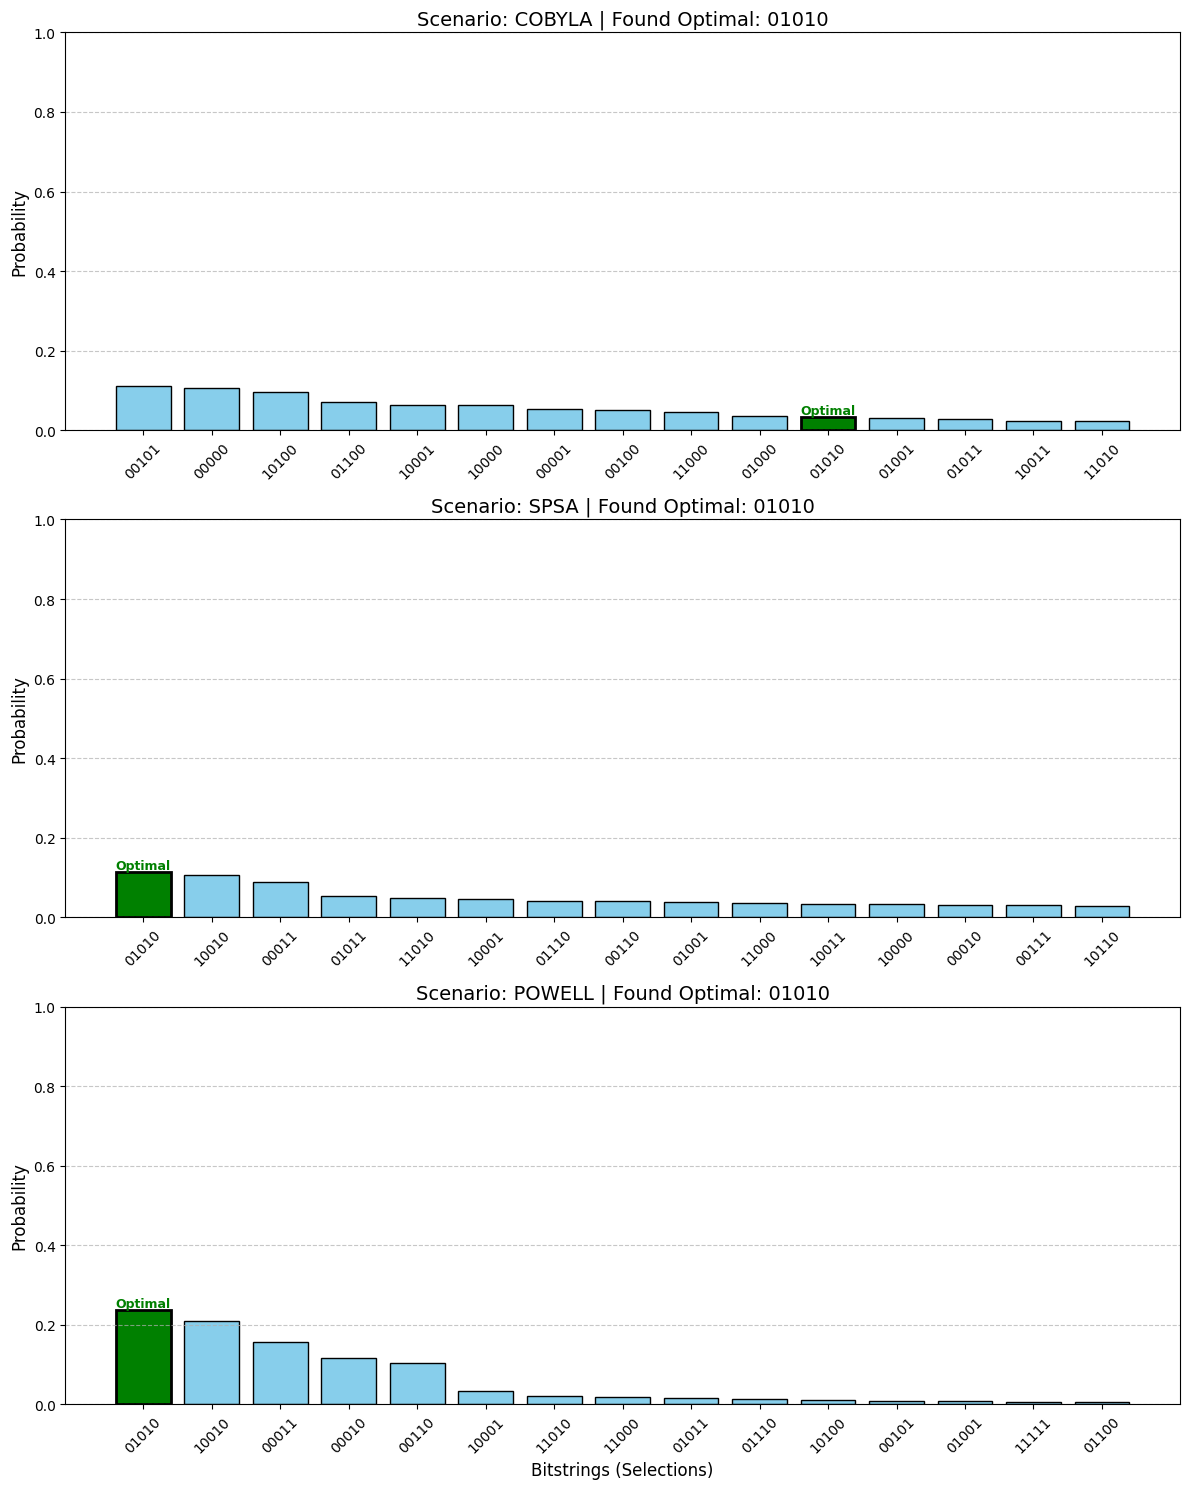

In [ ]:
#Parameters
tickers = ["AAPL", "GOOG", "MSFT","AMZN","META"]#["MRNA", "PFE","PYPL","ENPH", "SEDG"]+["AAPL", "GOOG", "MSFT", "TSLA","AMZN","META","NVDA","NFLX"]#+["MRNA", "PFE", "ENPH", "SEDG", "WBA", "PYPL"]
start_date = "2023-01-01"
end_date = "2024-01-01"
n_stocks = len(tickers)//2
risk = 0.2

#Data Retrieval
mu_raw, sigma_raw, prices = get_portfolio_data(tickers, start_date, end_date)

#Normalization
#print("Expected Returns (mu):\n", mu_raw)
mu_norm, sigma_norm = normalize_data(mu_raw, sigma_raw)

#Portfolio QP Creation
qp_realdata, penalty,portfolio_qp = create_portfolio_qp(mu_norm,sigma_norm,q=risk,budget=n_stocks)

# Exact Solver Implementation
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp_realdata)

print_result(result,portfolio_qp)


# QAOA Implementation
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=20)
result = qaoa.solve(qp_realdata)


print_result(result,portfolio_qp)


iter=200
p = 3
optimizers_to_test = {
        "COBYLA": COBYLA(maxiter=iter),
        "SPSA": SPSA(maxiter=iter),
        "POWELL": POWELL(maxiter=iter)
    }

# Assuming you have these variables defined from earlier in your code:
# mu_norm, sigma_norm, risk, n_stocks

experiment_results = run_qaoa_experiments(
    qp=qp_realdata,
    penalty=penalty,
    reps=3,
    optimizers_to_test=optimizers_to_test,
    mu=mu_norm,        
    sigma=sigma_norm,  
    q=risk,            
    budget=n_stocks    
)
plot_qaoa_results(experiment_results)

Function to generate different plots for each calssical optmizer

In [36]:
def run_qaoa_experiments(qp, penalty, reps, optimizers_to_test, mu, sigma, q, budget):
    """
    Runs QAOA using the provided optimizers, calculates approximation ratios, 
    and returns the results.
    """
    results_data = {}
    
    print(f"Running QAOA experiments with reps={reps}...")
    print(f"{'Optimizer':<10} | {'Ratio C(Z)':<8} | {'Value':<10} | {'Best String':<10}")
    print("-" * 55)
    
    for label, optimizer in optimizers_to_test.items():
        # Reset seed for fairness
        algorithm_globals.random_seed = 1234
        
        # Configure and Run
        qaoa_mes = QAOA(sampler=Sampler(), optimizer=optimizer, reps=reps)
        qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
        result = qaoa.solve(qp)
        
        # --- NEW: Calculate Approximation Ratio ---
        # We pass the result object directly to the helper function
        ratio = get_aproximation_ratio(result, mu, sigma, q, budget)
        
        # Capture optimal string ("1100")
        found_optimal_str = "".join(str(int(x)) for x in result.x)
        
        # Extract Probabilities
        eigenstate = result.min_eigen_solver_result.eigenstate
        probabilities = (
            eigenstate.binary_probabilities()
            if hasattr(eigenstate, 'binary_probabilities')
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
        
        sorted_probs = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
        
        # Store Data (Added 'ratio' to the dictionary)
        results_data[label] = {
            "probs": sorted_probs,
            "optimal_str": found_optimal_str,
            "optimal_val": result.fval,
            "ratio": ratio
        }
        
        # Print nicely formatted row
        print(f"{label:<10} | {ratio:.4f}   | {result.fval:.4f}     | {found_optimal_str}")
        
    return results_data

def plot_qaoa_results(results_data):
    """
    Plots histograms from the data dictionary returned by run_qaoa_experiments.
    Highlights the optimal solution found in each run in GREEN.
    """
    num_plots = len(results_data)
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, 5 * num_plots))
    
    # Handle single plot case (axes is not a list if nrows=1)
    if num_plots == 1:
        axes = [axes]
    
    for i, (label, data) in enumerate(results_data.items()):
        ax = axes[i]
        probs = data["probs"]
        run_optimal_str = data["optimal_str"]
        
        # Plot top 15 only
        top_n = 15
        bitstrings_raw = list(probs.keys())[:top_n]
        values = list(probs.values())[:top_n]
        
        # Reverse strings for plotting: Qiskit '0011' -> Label '1100'
        labels = [b[::-1] for b in bitstrings_raw]
        
        bars = ax.bar(labels, values, color='skyblue', edgecolor='black')
        
        # Highlight Logic
        found_in_top_n = False
        for bar, plot_label in zip(bars, labels):
            if plot_label == run_optimal_str:
                bar.set_facecolor('green')
                bar.set_linewidth(2)
                found_in_top_n = True
                
                # Add "Optimal" text above bar
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        'Optimal', ha='center', va='bottom', fontsize=9, color='green', fontweight='bold')

        # Formatting
        ax.set_title(f"Scenario: {label} | Found Optimal: {run_optimal_str}", fontsize=14)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_ylim(0, 1.0)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        if not found_in_top_n:
            ax.text(0.95, 0.95, f"Optimal ({run_optimal_str}) not in top {top_n}!", 
                    transform=ax.transAxes, color='red', ha='right', fontweight='bold')

    plt.xlabel("Bitstrings (Selections)", fontsize=12)
    plt.tight_layout()
    plt.show()

Test different classical optmizers for QAOA

Running QAOA experiments with reps=3...
Optimizer  | Ratio C(Z) | Value      | Best String
-------------------------------------------------------
COBYLA     | 1.0000   | -0.7247     | 01010
SPSA       | 1.0000   | -0.7247     | 01010
POWELL     | 1.0000   | -0.7247     | 01010


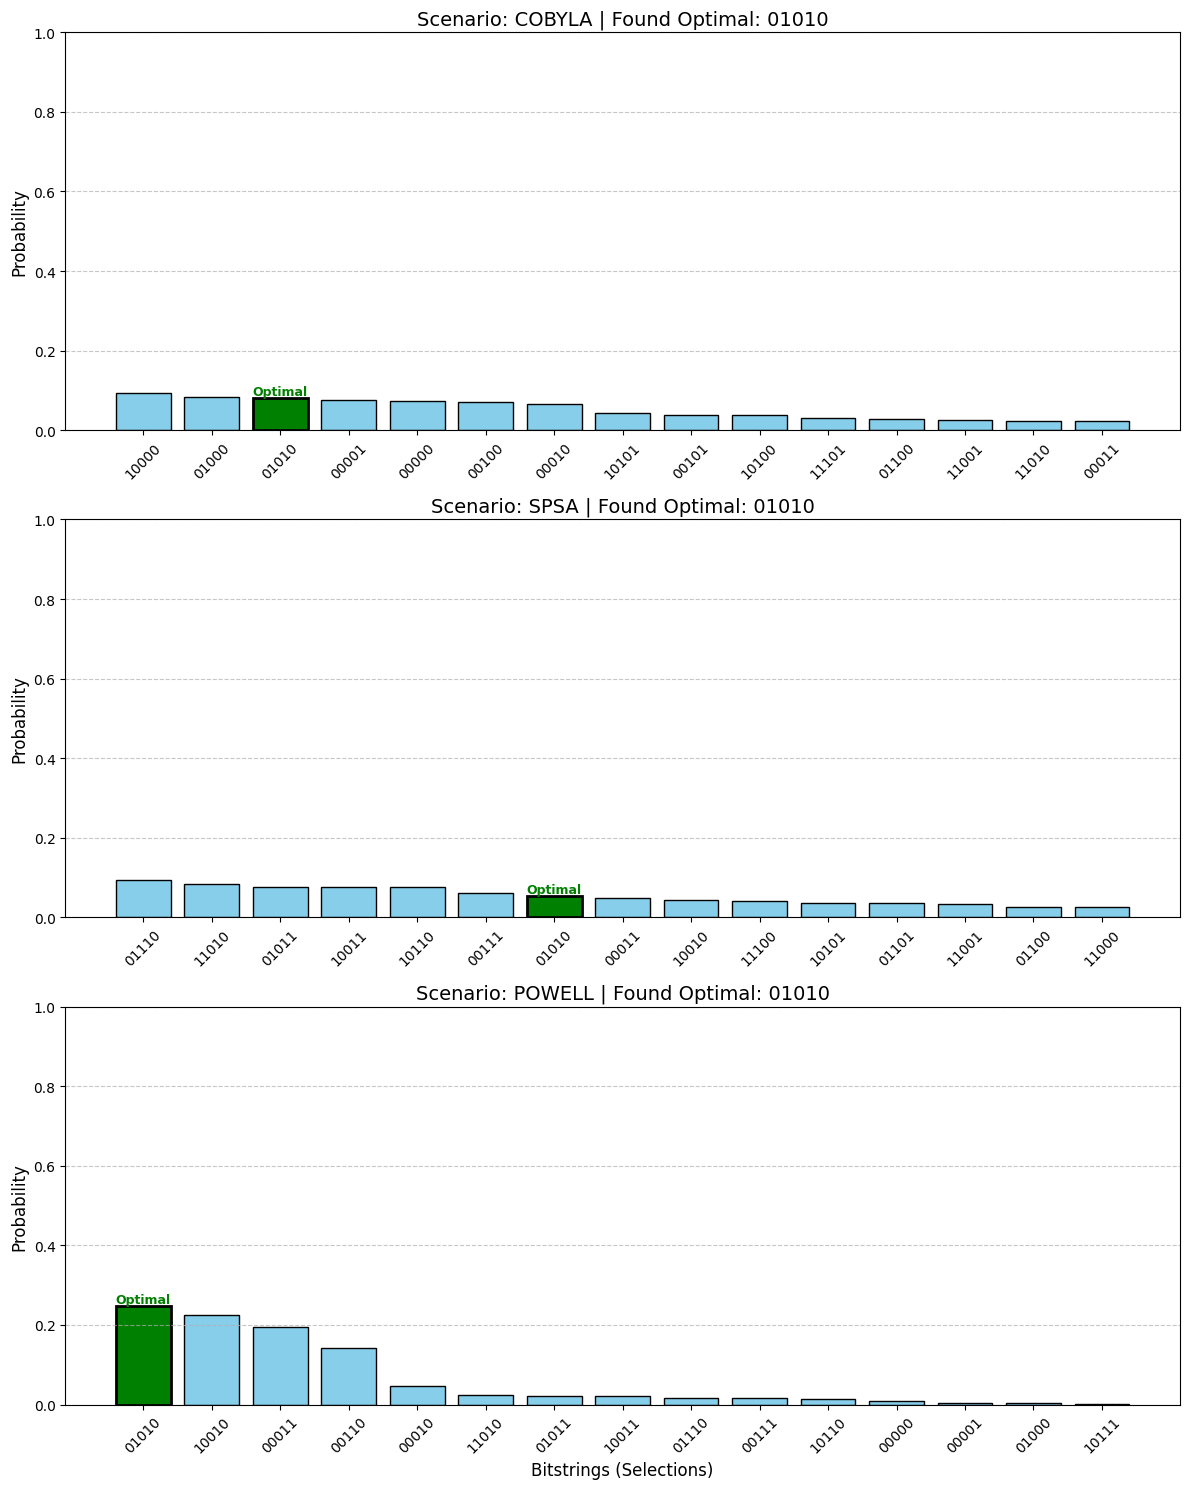

In [37]:
iter=200
p = 3
optimizers_to_test = {
        "COBYLA": COBYLA(maxiter=iter),
        "SPSA": SPSA(maxiter=iter),
        "POWELL": POWELL(maxiter=iter)
    }

# Assuming you have these variables defined from earlier in your code:
# mu_norm, sigma_norm, risk, n_stocks

experiment_results = run_qaoa_experiments(
    qp=qp_realdata,
    penalty=penalty,
    reps=3,
    optimizers_to_test=optimizers_to_test,
    mu=mu_norm,        
    sigma=sigma_norm,  
    q=risk,            
    budget=n_stocks    
)
plot_qaoa_results(experiment_results)